In [1]:
from pathlib import Path
import tensorflow as tf, pickle
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt   
import numpy as np

2025-06-18 18:01:35.410328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750262495.448453   10850 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750262495.457752   10850 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750262495.506130   10850 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750262495.506170   10850 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750262495.506172   10850 computation_placer.cc:177] computation placer alr

In [4]:
today     = datetime.now().strftime("%Y-%m-%d")

# ── 1 · load model (architecture + weights already inside) ────────────
save_dir   = Path("dfs training")
ticker     = "AAPL"
file_path = save_dir / f"model_{ticker}_{today}.keras"
model      = tf.keras.models.load_model(file_path)

# (optional) re-load weights-only checkpoint in case you updated it
ckpt_path  = save_dir / f"best_{ticker}.weights.h5"
model.load_weights(ckpt_path)      # harmless if identical

# ── 2 · load tf.data test set exactly as it was saved ─────────────────
spec      = pickle.loads((save_dir / f"ds_test_{ticker}.pkl").read_bytes())
ds_test   = tf.data.Dataset.load(str(save_dir / "ds_test_data"),
                                 element_spec=spec,
                                 compression="GZIP")



In [5]:
# ── 3 · evaluate RMSE day-by-day (stateful, 1-bar horizon) ────────────
lstm_layers = [l for l in model.layers if hasattr(l, "reset_states")]
test_metric = tf.keras.metrics.RootMeanSquaredError(name="rmse")

N_test = sum(1 for _ in ds_test)          # concrete length for tqdm
ds_test = ds_test.cache()                 # keep in RAM/GPU

for X_day, y_day, _ in tqdm(ds_test, total=N_test, unit="day", desc="Testing"):
    for l in lstm_layers: l.reset_states()

    y_pred = model(X_day, training=False)         # shape (1, T, 1)
    y_pred = tf.squeeze(y_pred, (0, 2))           #  → (T,)

    # align: compare ŷ(t) with y(t+1)
    y_true = tf.squeeze(y_day)                    # (T,)
    test_metric.update_state(y_true[1:], y_pred[:-1])

print(f"\nFINAL OOS TEST RMSE (1-bar ahead) = {test_metric.result():.5f}")


Testing:   0%|          | 0/16 [00:00<?, ?day/s]

I0000 00:00:1750262842.002180   10916 cuda_dnn.cc:529] Loaded cuDNN version 91002



FINAL OOS TEST RMSE (1-bar ahead) = 0.25507


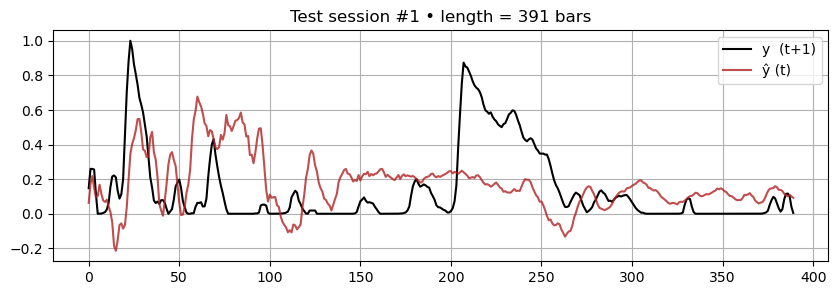

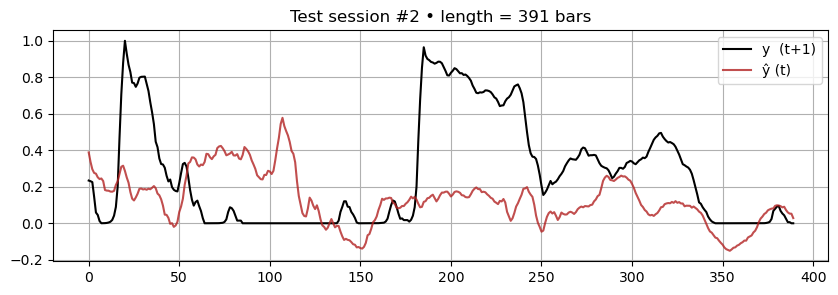

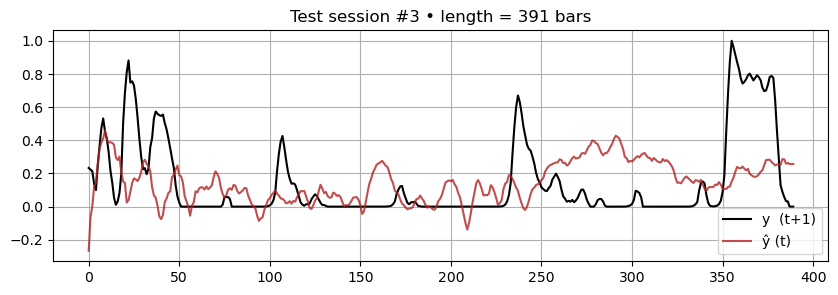

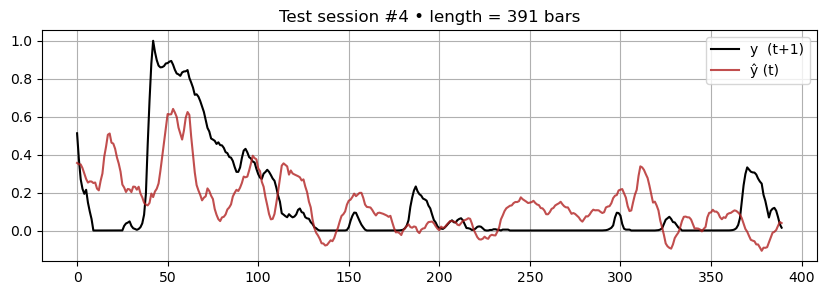

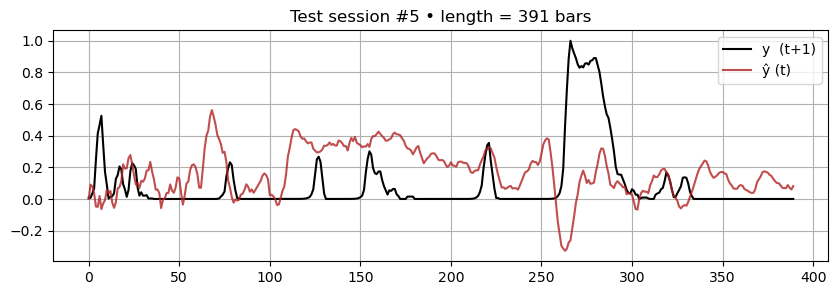

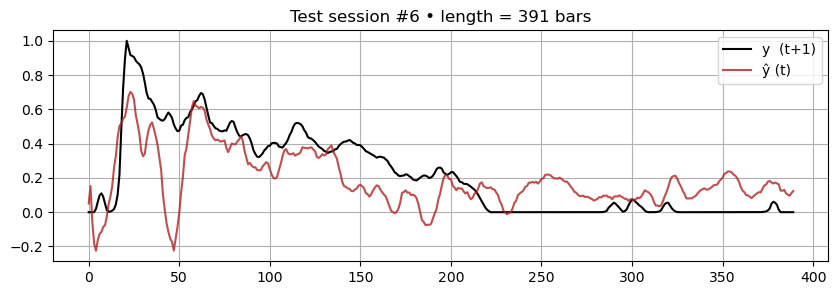

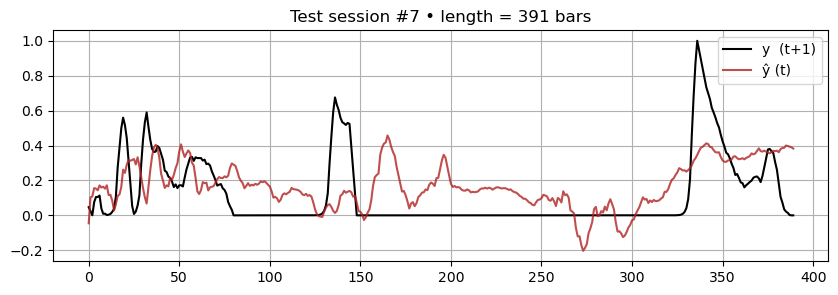

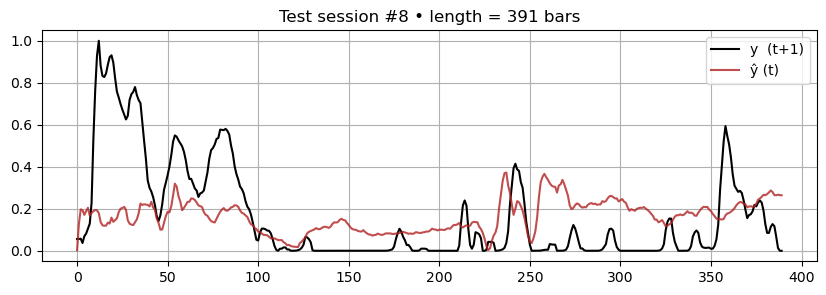

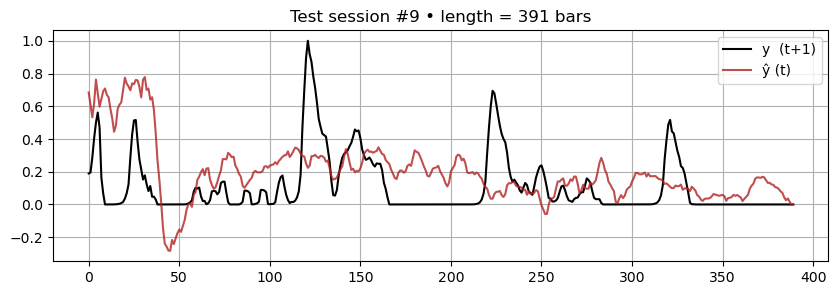

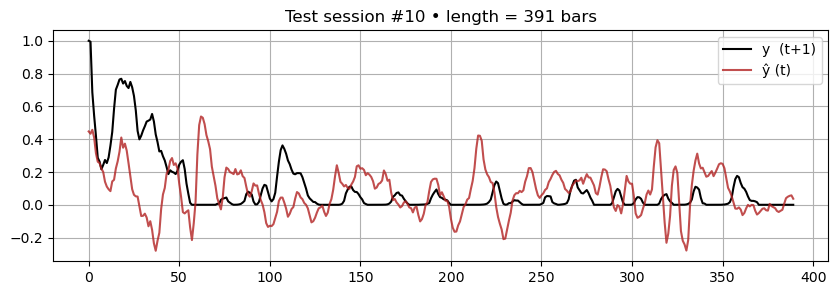

In [6]:
# ── 4 · quick visual sanity check ─────────────────────────────────────
N_PLOTS, plotted = 10, 0

for X_day, y_day, _ in ds_test:
    for l in lstm_layers: l.reset_states()

    y_hat  = model(X_day, training=False).numpy().squeeze()   # (T,)
    y_true = y_day.numpy().squeeze()                          # (T,)

    shift = 1                             # horizon in bars
    plt.figure(figsize=(10, 3))
    plt.plot(y_true[shift:],            label="y  (t+1)", color="black")
    plt.plot(y_hat[:-shift], alpha=.8,  label="ŷ (t)",   color="firebrick")
    plt.title(f"Test session #{plotted+1} • length = {len(y_true)} bars")
    plt.legend(); plt.grid(True); plt.show()

    plotted += 1
    if plotted >= N_PLOTS:
        break


In [7]:
# to confirm the shift of the prediction above (we are predicting the next signal, so we need to align it with the label for visualization)

corr_curr = np.corrcoef(y_true,         y_hat        )[0,1]
corr_lag1 = np.corrcoef(y_true[:-1],    y_hat[1:]    )[0,1]  # ŷ leads by 1
corr_lag_1 = np.corrcoef(y_true[1:],    y_hat[:-1]   )[0,1]  # ŷ lags  by 1

print(f"zero-lag   : {corr_curr:6.3f}")
print(f"ŷ leads 1 : {corr_lag1:6.3f}")
print(f"ŷ lags 1  : {corr_lag_1:6.3f}")


rmse_curr = np.sqrt(np.mean((y_true      - y_hat)      ** 2))
rmse_lead = np.sqrt(np.mean((y_true[:-1] - y_hat[1:]) ** 2))

print("RMSE  curr :", rmse_curr)
print("RMSE  lead :", rmse_lead)


zero-lag   :  0.133
ŷ leads 1 :  0.102
ŷ lags 1  :  0.135
RMSE  curr : 0.21537212
RMSE  lead : 0.21865988
